# Q1

## Part a

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr, f_oneway
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breuschpagan, het_white, linear_reset
from statsmodels.stats.stattools import jarque_bera
from scipy.stats import shapiro, kendalltau
from sklearn.linear_model import TheilSenRegressor
from statsmodels.stats.outliers_influence import OLSInfluence

In [ ]:
df = pd.read_excel("Doktar_Topology_Sample_Data_20250627.xlsx")
df.columns = (df.columns.str.strip().str.replace(" ", "_", regex=False).str.replace("(", "", regex=False).str.replace(")", "", regex=False))
df.head(10)

,#,Measured_VMC_%,Normalized_Values,Sensor,Soil_Type,Test_Take
0,1,10.15,4770,Upper,Location-1,1
1,2,9.89,4768,Upper,Location-1,1
2,3,15.73,5315,Upper,Location-1,1
3,4,16.25,5319,Upper,Location-1,1
4,5,23.18,6672,Upper,Location-1,1
5,6,21.44,6692,Upper,Location-1,1
6,7,28.63,7014,Upper,Location-1,1
7,8,31.72,7019,Upper,Location-1,1
8,9,36.95,8892,Upper,Location-1,1
9,10,37.44,8887,Upper,Location-1,1


In [ ]:
print("Basic info")
df.info()

Basic info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 272 entries, 0 to 271
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   #                  272 non-null    int64  
 1   Measured_VMC_%     272 non-null    float64
 2   Normalized_Values  272 non-null    int64  
 3   Sensor             272 non-null    object 
 4   Soil_Type          272 non-null    object 
 5   Test_Take          272 non-null    int64  
dtypes: float64(1), int64(3), object(2)
memory usage: 12.9+ KB


In [ ]:
print("\nMissing values by column:\n", df.isna().sum())


Missing values by column:
 #                    0
Measured_VMC_%       0
Normalized_Values    0
Sensor               0
Soil_Type            0
Test_Take            0
dtype: int64


In [ ]:
# Numeric Summary
num_cols = ["Measured_VMC_%", "Normalized_Values"]
summary = df[num_cols].describe().round(2)
summary.loc["median"] = df[num_cols].median().round(2)
print("\nDescriptive statistics (Numeric) including median:\n")
print(summary)


Descriptive statistics (Numeric) including median:

        Measured_VMC_%  Normalized_Values
count           272.00             272.00
mean             20.96            5855.97
std              12.28            2060.71
min               3.26            1578.00
25%              10.15            4434.75
50%              17.94            5755.50
75%              32.35            7291.00
max              46.16            9830.00
median           17.94            5755.50


272 observations for both variables. It is enough for summary estimates and for splitting into train-validation folds without losing much power.

For VMC the mean is greater the median, which hints at a slight tail to the right. Mild positive skew. Extreme wet samples may pull the average up.

For normalized values the mean and median nearly coincide, which signals a symmetric shape. These statistics will be further analyzed with histograms.

The VMC readings span from very dry (< 5 %) to close to field saturation (> 45 %). Normalized Values cover almost the full 0 - 10000 scale.


In [ ]:
# Per Categorical Group Summary
cat_cols = [c for c in df.columns if df[c].dtype == "object"]
print("\nCategorical columns detected:", cat_cols)

for col in cat_cols:
    print(f"\nGrouped by {col}")
    print(df.groupby(col)[num_cols].agg(["count", "mean", "std", "min", "max"]).round(2))


Categorical columns detected: ['Sensor', 'Soil_Type']

Grouped by Sensor
       Measured_VMC_%                            Normalized_Values           \
                count   mean    std   min    max             count     mean   
Sensor                                                                        
Lower              98  21.18  12.37  3.26  46.16                98  5628.33   
Middle            100  21.61  12.59  3.26  45.05               100  6009.02   
Upper              74  19.78  11.83  3.26  40.54                74  5950.61   

                             
            std   min   max  
Sensor                       
Lower   2337.14  1578  9830  
Middle  1988.02  2387  9363  
Upper   1742.37  2914  9340  

Grouped by Soil_Type
           Measured_VMC_%                            Normalized_Values  \
                    count   mean    std   min    max             count   
Soil_Type                                                                
Location-1            230  

Standard deviations are similar across groups, so heteroscedasticity by group is not a concern.

For Sensor Grouping:

VMS means: 21.2 %, 21.6 %, 19.8 %. All within ±1.8 % of the overall average.

Normalized Values' means: 5628, 6009, 5951. Also tightly clustered.

For Soil Type Grouping:

VMS means: 21.4 % vs 18.3 %. a 3 % gap requires ANOVA testing to further understand the effect of soil type.

Normalized Values' means: 5795 vs 6191. About 400 counts higher on Location-2 even though moisture reads lower.

With only 42 samples of Location-2, it is hard to decide if this is a true physical effect or sampling noise.

Depth of the sensor does not require special treatment. Soil type may need attention once more statistical testing is done.

In [ ]:
# ANOVA by Groups
def one_way_anova(target, group_col):
    groups = [g[target].values for _, g in df.groupby(group_col)]
    f_stat, p_val = f_oneway(*groups)
    return f_stat, p_val

for col in cat_cols:
    f_vmc, p_vmc = one_way_anova("Measured_VMC_%", col)
    f_norm, p_norm = one_way_anova("Normalized_Values", col)
    print(f"\nANOVA for Measured_VMC_% across {col}: F={f_vmc:.2f}, p={p_vmc:.3f}")
    print(f"ANOVA for Normalized_Values across {col}: F={f_norm:.2f}, p={p_norm:.3f}")


ANOVA for Measured_VMC_% across Sensor: F=0.50, p=0.608
ANOVA for Normalized_Values across Sensor: F=0.95, p=0.387

ANOVA for Measured_VMC_% across Soil_Type: F=2.28, p=0.132
ANOVA for Normalized_Values across Soil_Type: F=1.31, p=0.253


ANOVA results for all combinations failed to reject H₀, which means statistically soil type and sensor depth have no significant effect on VMC and Normalized Values. However, this could be due to small size of the grouped dataset. For example, there are only 42 instances for Location-2. With a larger dataset, we might see the real effect od soil type and sensor depth to VMC and Normalized Values.

1. Test Results for VMC % ~ Sensor:

Null hypothesis (H₀): Mean VMC is equal at Lower, Middle, Upper depths.

Decision at α = 0.05: Fail to reject H₀.

Result: Depth does not change VMC readings.

2. Test Results for Normalized Values ~ Sensor:

Null hypothesis (H₀): Mean Normalized_Values are equal by depth.

Decision at α = 0.05: Fail to reject H₀.

Result: Depth does not change normalized values.

3. Test Results for VMC % ~ Soil_Type:

Null hypothesis (H₀): Mean VMC is the same in Location-1 and Location-2.

Decision at α = 0.05: Fail to reject H₀.

Result: Moisture looks ~3 % lower in Location-2. Evidence is not so strong, but ANOVA test suggest that the soil type has no significant effect on VMC.

4. Test Results for Normalized Values ~ Soil_Type:

Null hypothesis (H₀): Mean Normalized_Values is the same by soil type.

Decision at α = 0.05: Fail to reject H₀.

Result: Normalized Values' are ~400 higher in Location-2, yet still inside random variation.

In [ ]:
# Correlation
pearson_r, p_p = pearsonr(df["Normalized_Values"], df["Measured_VMC_%"])
spearman_rho, p_s = spearmanr(df["Normalized_Values"], df["Measured_VMC_%"])
print(f"\nPearson r: {pearson_r:.3f}  (p={p_p:.1e})")
print(f"Spearman ρ: {spearman_rho:.3f} (p={p_s:.1e})")


Pearson r: 0.916  (p=3.3e-109)
Spearman ρ: 0.937 (p=6.1e-125)


Pearson r: Measures linear association. A value above 0.9 means the data cloud lies very close to a straight line.

Spearman ρ: Measures monotone association (rank-based). Being even higher than Pearson confirms that when one variable increases, the other almost always increases as well, even if the rise is not perfectly linear.

Modeling implications:

- A simple linear model will already perform reasonably well.

- Because ρ > r, a monotonic but non-linear model (isotonic regression or a monotonic GBM) can capture the subtle bend and reduce error further.

- The high correlation also means multicollinearity is a non-issue here.

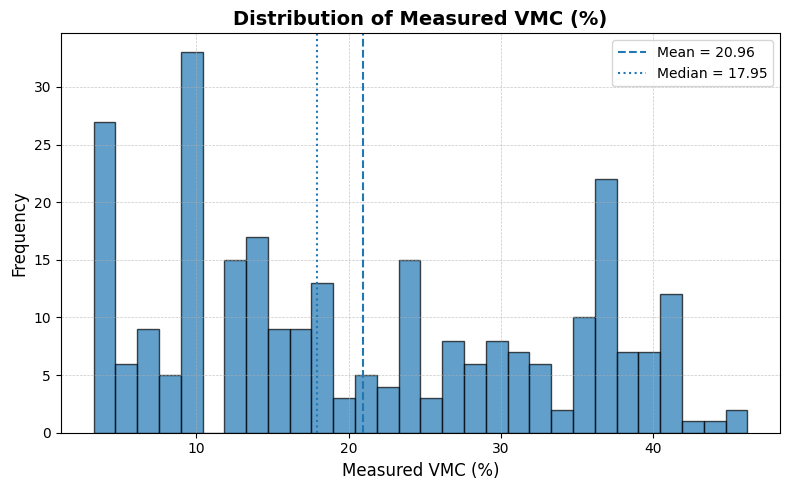

In [ ]:
# Histogram for VMC
plt.figure(figsize=(8, 5))
plt.hist(df["Measured_VMC_%"], bins=30, edgecolor="black", alpha=0.7)
mean_val = df["Measured_VMC_%"].mean()
median_val = df["Measured_VMC_%"].median()
plt.axvline(mean_val, linestyle='--', linewidth=1.5, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, linestyle=':', linewidth=1.5, label=f"Median = {median_val:.2f}")
plt.xlabel("Measured VMC (%)", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Measured VMC (%)", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Central tendency vs skew: The median (17.95 %) sits below the mean (20.96 %), which indicates a mild right skew. A handful of very wet samples pull the average up.

Multi-modal hints: We can see one cluster of readings around 8-12 % (dry conditions) and another looser cluster around 30-40 % (near-saturation). That may correspond to different irrigation regimes or soil textures in your test batches.

Spread and outliers: Most values fall between 5 % and 45 %, with very few extremes below 5 % or above 45 %. Those edge cases merit a quick quality check (sensor noise or true field extremes).


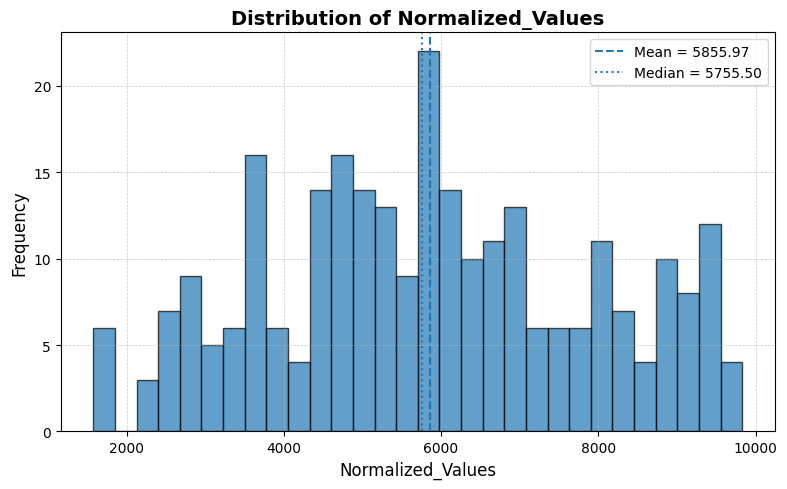

In [ ]:
# Histogram for Normalized Values
plt.figure(figsize=(8, 5))
plt.hist(df["Normalized_Values"], bins=30, edgecolor="black", alpha=0.7)
mean_val = df["Normalized_Values"].mean()
median_val = df["Normalized_Values"].median()
plt.axvline(mean_val, linestyle='--', linewidth=1.5, label=f"Mean = {mean_val:.2f}")
plt.axvline(median_val, linestyle=':', linewidth=1.5, label=f"Median = {median_val:.2f}")
plt.xlabel("Normalized_Values", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.title("Distribution of Normalized_Values", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

Symmetry: Mean (5855.97) and median (5755.50) are almost identical, which confirms a roughly symmetric distribution.

No severe outliers: The absence of isolated bars far from the bulk means your sensor behaved consistently and you can trust the calibration across its entire dynamic range.

Modeling takeaway: A linear model can already capture much of this symmetry, but the minor undulations (for example, that mid-range plateau) explain why a piece-wise monotonic fit (isotonic regression) further can reduce error.

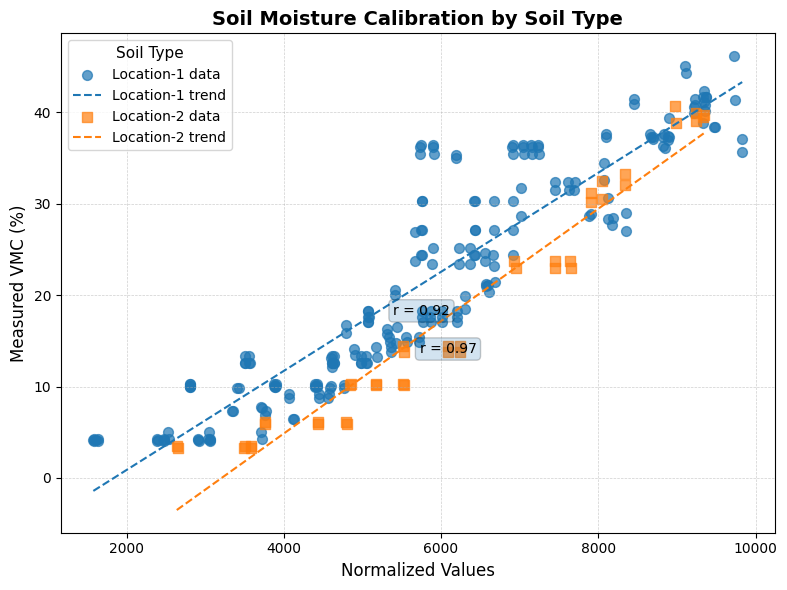

In [ ]:
# Scatter based on Soil Type
plt.figure(figsize=(8, 6))
markers = ['o', 's']
for (soil, grp), marker in zip(df.groupby("Soil_Type"), markers):
    x = grp["Normalized_Values"]
    y = grp["Measured_VMC_%"]
    plt.scatter(x, y, marker=marker, s=50, alpha=0.7, label=f"{soil} data")
    m, b = np.polyfit(x, y, 1)
    xs = np.array([x.min(), x.max()])
    plt.plot(xs, m*xs + b, linestyle='--', linewidth=1.5, label=f"{soil} trend")
    r, _ = pearsonr(x, y)
    plt.text(np.median(x), np.median(y),
             f"r = {r:.2f}",
             fontsize=10, ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", alpha=0.2))

plt.xlabel("Normalized Values", fontsize=12)
plt.ylabel("Measured VMC (%)", fontsize=12)
plt.title("Soil Moisture Calibration by Soil Type", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(title="Soil Type", fontsize=10, title_fontsize=11, loc='upper left')

plt.tight_layout()
plt.show()

Strong within-soil linearity:
- Both Location-1 and Location-2 points hug their trend lines tightly.
- Pearson r annotations (≈ 0.92 vs. 0.97) confirm that each soil's counts map almost perfectly to moisture in a straight-line fashion.

Slight slope difference:
- Location-2's line is marginally steeper, meaning its sensor reacts a bit more sharply per count unit—but starts lower.
- Practically, that means a simple soil-specific bias term could realign the two curves without retraining a full new model.



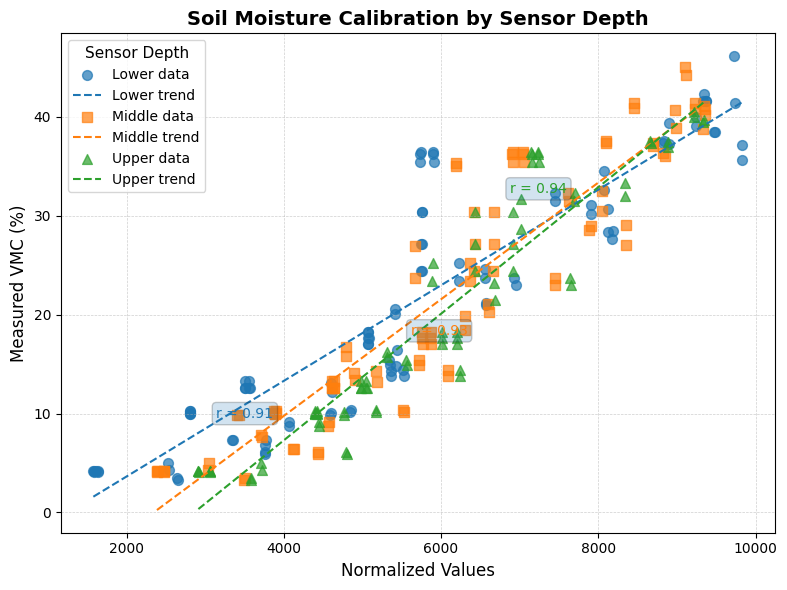

In [ ]:
# Scatter based on Sensor Depth
plt.figure(figsize=(8, 6))
sensors = ['Lower', 'Middle', 'Upper']
markers = {'Lower': 'o', 'Middle': 's', 'Upper': '^'}
colors = {'Lower': 'C0', 'Middle': 'C1', 'Upper': 'C2'}
quantiles = {'Lower': 0.2, 'Middle': 0.5, 'Upper': 0.8}

for sensor in sensors:
    grp = df[df['Sensor'] == sensor]
    x = grp["Normalized_Values"]
    y = grp["Measured_VMC_%"]
    plt.scatter(x, y, marker=markers[sensor], s=50, alpha=0.7,
                color=colors[sensor], label=f"{sensor} data")
    m, b = np.polyfit(x, y, 1)
    xs = np.array([x.min(), x.max()])
    plt.plot(xs, m * xs + b, linestyle='--', linewidth=1.5,
             color=colors[sensor], label=f"{sensor} trend")
    r, _ = pearsonr(x, y)
    x_pos = np.quantile(x, quantiles[sensor])
    y_pos = np.quantile(y, quantiles[sensor])
    plt.text(x_pos, y_pos, f"r = {r:.2f}", fontsize=10,
             ha='center', va='center',
             bbox=dict(boxstyle="round,pad=0.3", alpha=0.2),
             color=colors[sensor])

plt.xlabel("Normalized Values", fontsize=12)
plt.ylabel("Measured VMC (%)", fontsize=12)
plt.title("Soil Moisture Calibration by Sensor Depth", fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)
plt.legend(title="Sensor Depth", fontsize=10, title_fontsize=11, loc='upper left')

plt.tight_layout()
plt.show()

Depth invariance:
- All three trend lines remain nearly parallel, which reinforces that calibration doesn't depend on sensor depth.

High fidelity at every depth:
- Correlations of ~0.91 - 0.94 at Lower, Middle and Upper depths show equally tight linear fits.

Small intercept shifts:
- Slight vertical offsets between lines are within 1-2 % VMC, matching the non-significant ANOVA p-values we saw earlier (p ≈ 0.6).

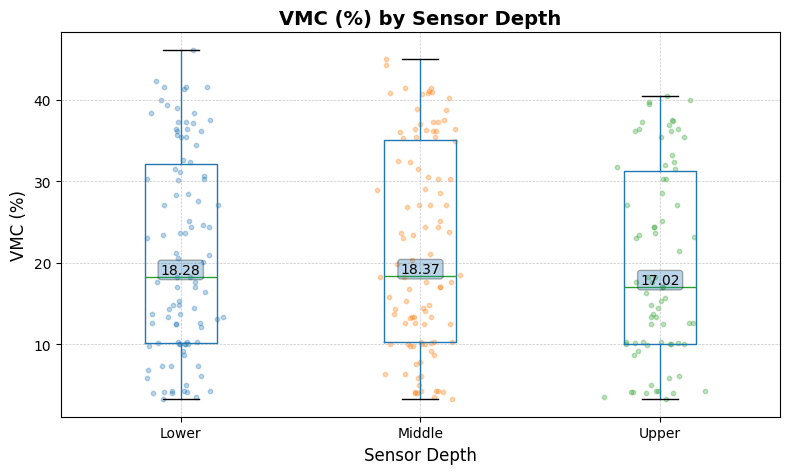

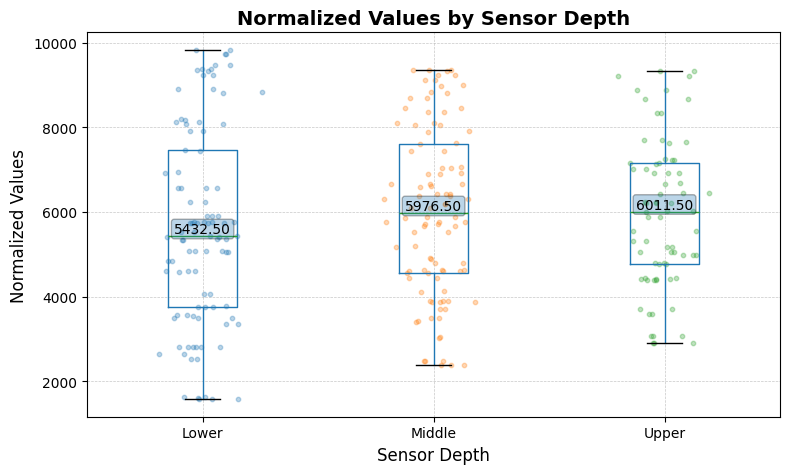

In [ ]:
# Boxplot for VMC based on Sensor Depth
plt.rcParams.update({'axes.titlesize': 14, 'axes.labelsize': 12})
for column, ylabel in [("Measured_VMC_%", "VMC (%)"),
                       ("Normalized_Values", "Normalized Values")]:
    fig, ax = plt.subplots(figsize=(8, 5))
    box = df.boxplot(column=column, by="Sensor", ax=ax, patch_artist=False)

    medians = df.groupby("Sensor")[column].median()
    positions = np.arange(1, len(medians) + 1)
    for pos, sensor in zip(positions, medians.index):
        y = df[df["Sensor"] == sensor][column]
        x = np.random.normal(pos, 0.08, size=len(y))
        ax.scatter(x, y, alpha=0.3, s=10)

    for pos, med in zip(positions, medians):
        ax.text(pos, med, f"{med:.2f}", ha='center', va='bottom', fontsize=10,
                bbox=dict(boxstyle="round,pad=0.2", alpha=0.3))

    ax.set_title(f"{ylabel} by Sensor Depth", fontweight='bold')
    ax.set_xlabel("Sensor Depth")
    ax.set_ylabel(ylabel)
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
    plt.suptitle("")
    plt.tight_layout()
    plt.show()
    print("")

In [ ]:
X = df["Normalized_Values"]
y = df["Measured_VMC_%"]

In [ ]:
# OLS regression
X_mat = sm.add_constant(X)
ols_model = sm.OLS(y, X_mat).fit()
print("OLS Regression Summary:\n", ols_model.summary())

OLS Regression Summary:
                             OLS Regression Results                            
Dep. Variable:         Measured_VMC_%   R-squared:                       0.839
Model:                            OLS   Adj. R-squared:                  0.839
Method:                 Least Squares   F-statistic:                     1411.
Date:                Mon, 30 Jun 2025   Prob (F-statistic):          3.30e-109
Time:                        21:28:26   Log-Likelihood:                -819.05
No. Observations:                 272   AIC:                             1642.
Df Residuals:                     270   BIC:                             1649.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const        

R² ≈ 0.84 and F-statistic p ≪ 10⁻⁶ confirm a highly significant linear relationship.

Goodness of fit: 84% of the variance in measured VMC is explained by the Normalized Values with a single linear term, strong but not perfect.

Coefficients: intercept ≈ -11.03, slope ≈ 0.0055 (% VMC per count).

Linear Regression Formula: VMC = -11.03 + 0.0055 x Normalized_Values

Autocorrelation: Durbin-Watson = 0.48. DW = 2 means no residual autocorrelation. 0.48 is far below 2. Residuals are positively correlated in sequence order (likely because data are ordered by test run). This mostly affects inference, not predictive accuracy.

Skewness (≈ +0.80): Measures asymmetry of the residual distribution. A value of 0 would be perfectly symmetric. This skew (~0.8) means there are more or larger positive errors (the model under-predicts high moisture values more often than it over-predicts).

Kurtosis (≈ 3.77): Measures tailedness or peakness. A normal distribution has kurtosis = 3. A value > 3 indicates heavier tails and a sharper peak, so more outliers than a Gaussian would predict.

In [ ]:
# Heteroscedasticity tests
bp_lm, bp_p, _, _ = het_breuschpagan(ols_model.resid, ols_model.model.exog)
white_lm, white_p, _, _ = het_white(ols_model.resid, ols_model.model.exog)
print(f"\nBreusch–Pagan p-value: {bp_p:.3f}")
print(f"White test p-value: {white_p:.3f}")


Breusch–Pagan p-value: 0.840
White test p-value: 0.001


Breusch-Pagan p = 0.840:

- Null hypothesis: residual variance is a linear function of the predictor (Normalized_Values)
- p > 0.05: no evidence of a simple fan-shape (variance increasing or decreasing linearly with counts).

White test p = 0.001:

- Null hypothesis: residual variance is constant.

- Alternative: variance can be any (possibly nonlinear) function of the predictor (and also detects certain misspecifications in the mean model).

- p < 0.05: strong evidence that variance is not constant in some complex way.

There's no need for a weighted least squares fix targeting a linear variance pattern. However, the White test's rejection hints at a more complicated variance or mean-model misspecification, exactly what the Ramsey RESET and residual plots showed (mild curvature).

If we stick with OLS for inference, switch to heteroscedasticity-robust standard errors (e.g. HC3).

Update After Part b: For prediction, isotonic regression already absorbs that nonlinearity and yielded homoscedastic residuals in earlier diagnostics, so we can safely use that model.

In [ ]:
# Nonlinearity (Ramsey RESET)
reset_test = linear_reset(ols_model, power=2, use_f=True)
print(f"\nRamsey RESET test: F = {reset_test.fvalue:.2f}, p = {reset_test.pvalue:.3f}")


Ramsey RESET test: F = 6.00, p = 0.015


Ramsey RESET p = 0.015 indicates the model omits non-linear terms. The linear specification is missing non-linear terms.

Update After Part b: This aligns with scatterplot curvature and why isotonic/GBM outperform OLS.

Linear fit is statistically sound (F-test, stable variance) but residual non-normality and RESET p-value reiterate the benefit of a non-parametric monotonic fit.

## Part b

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.isotonic import IsotonicRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [ ]:
# Features & target arrays
X = df[["Normalized_Values"]].values
y = df["Measured_VMC_%"].values

# CANDIDATE MODELS
models = {
    # Pure linear regression
    "Linear": Pipeline([
        ("lr", LinearRegression())
    ]),

    # Polynomial (degree 2) to capture slight curvature
    "Poly deg=2": Pipeline([
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lr",   LinearRegression())
    ]),

    # Isotonic regression: non-parametric, strictly monotonic
    "Isotonic": IsotonicRegression(out_of_bounds="clip"),

    # Monotonic GBM: powerful, enforces increasing shape
    "Monotonic GBM": HistGradientBoostingRegressor(
        monotonic_cst=[1], # enforce y’ >= 0
        max_iter=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    ),
}

print("Candidate models and their parameters:")
for name, mdl in models.items():
    print(f" • {name}: {mdl}")
print()

Candidate models and their parameters:
 • Linear: Pipeline(steps=[('lr', LinearRegression())])
 • Poly deg=2: Pipeline(steps=[('poly', PolynomialFeatures(include_bias=False)),
                ('lr', LinearRegression())])
 • Isotonic: IsotonicRegression(out_of_bounds='clip')
 • Monotonic GBM: HistGradientBoostingRegressor(max_depth=3, monotonic_cst=[1], random_state=42)



In [ ]:
# VALIDATION STRATEGY AND METRICS
kf = KFold(n_splits=3, shuffle=True, random_state=42)
metric_names = ["RMSE", "MAE", "R2"]
cv_records = []

for model_name, model in models.items():
    rmse_scores = []
    mae_scores  = []
    r2_scores   = []

    print(f"Running 3-fold CV for {model_name}")
    for fold, (train_idx, val_idx) in enumerate(kf.split(X), start=1):
        X_train, X_val = X[train_idx], X[val_idx]
        y_train, y_val = y[train_idx], y[val_idx]

        # Fit model
        if model_name == "Isotonic":
            model.fit(X_train.ravel(), y_train)
            y_pred = model.predict(X_val.ravel())
        else:
            model.fit(X_train, y_train)
            y_pred = model.predict(X_val)

        # Compute metrics
        rmse = np.sqrt(mean_squared_error(y_val, y_pred))
        mae  = mean_absolute_error(y_val, y_pred)
        r2   = r2_score(y_val, y_pred)

        print(f"  Fold {fold}: RMSE={rmse:.3f}, MAE={mae:.3f}, R2={r2:.3f}")
        rmse_scores.append(rmse)
        mae_scores.append(mae)
        r2_scores.append(r2)

    cv_records.append({
        "Model": model_name,
        "RMSE_mean": np.mean(rmse_scores),
        "RMSE_std":  np.std(rmse_scores),
        "MAE_mean":  np.mean(mae_scores),
        "MAE_std":   np.std(mae_scores),
        "R2_mean":   np.mean(r2_scores),
        "R2_std":    np.std(r2_scores),
    })
    print()

cv_df = pd.DataFrame(cv_records).set_index("Model")
print("3-Fold CV Summary")
print(cv_df.round(3), "\n")

Running 3-fold CV for Linear
  Fold 1: RMSE=5.393, MAE=4.107, R2=0.803
  Fold 2: RMSE=4.627, MAE=3.711, R2=0.870
  Fold 3: RMSE=4.842, MAE=3.762, R2=0.828

Running 3-fold CV for Poly deg=2
  Fold 1: RMSE=5.371, MAE=3.950, R2=0.805
  Fold 2: RMSE=4.585, MAE=3.547, R2=0.872
  Fold 3: RMSE=4.772, MAE=3.715, R2=0.833

Running 3-fold CV for Isotonic
  Fold 1: RMSE=4.849, MAE=3.335, R2=0.841
  Fold 2: RMSE=3.925, MAE=2.932, R2=0.906
  Fold 3: RMSE=4.348, MAE=3.211, R2=0.861

Running 3-fold CV for Monotonic GBM
  Fold 1: RMSE=4.862, MAE=3.396, R2=0.840
  Fold 2: RMSE=3.926, MAE=3.002, R2=0.906
  Fold 3: RMSE=4.492, MAE=3.374, R2=0.852

3-Fold CV Summary
               RMSE_mean  RMSE_std  MAE_mean  MAE_std  R2_mean  R2_std
Model                                                                 
Linear             4.954     0.322     3.860    0.176    0.833   0.027
Poly deg=2         4.909     0.335     3.737    0.165    0.836   0.028
Isotonic           4.374     0.378     3.159    0.169    0.86

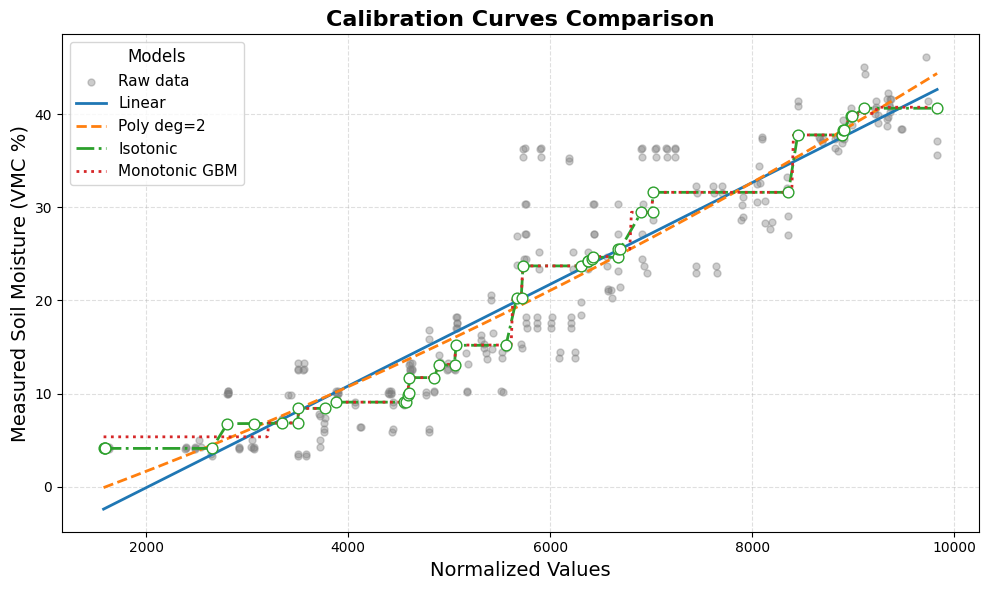

In [ ]:
# FINAL CALIBRATION CURVES (FULL DATA)
# Retrain each model on full dataset and plot its fit vs. raw data
xs = np.linspace(X.min(), X.max(), 500).reshape(-1, 1)
plt.figure(figsize=(10, 6))
plt.scatter(X, y, color="gray", alpha=0.4, s=25, label="Raw data")

colors = ["C0", "C1", "C2", "C3"]
linestyles = ["-", "--", "-.", ":"]
for (name, model), color, ls in zip(models.items(), colors, linestyles):
    if name == "Isotonic":
        model.fit(X.ravel(), y)
        ys = model.predict(xs.ravel())
        # Plot the piecewise-constant curve
        plt.plot(xs, ys, label=name, color=color, linestyle=ls, linewidth=2)
        knots_x = model.X_thresholds_
        knots_y = model.y_thresholds_
        plt.scatter(knots_x, knots_y,
                    edgecolor=color, facecolor="white", s=60, zorder=5)
    else:
        model.fit(X, y)
        ys = model.predict(xs)
        plt.plot(xs, ys,
                 label=name, color=color, linestyle=ls, linewidth=2)

plt.title("Calibration Curves Comparison", fontsize=16, fontweight="bold")
plt.xlabel("Normalized Values", fontsize=14)
plt.ylabel("Measured Soil Moisture (VMC %)", fontsize=14)
plt.grid(True, linestyle="--", alpha=0.4)
plt.legend(title="Models", title_fontsize=12, fontsize=11, loc="upper left")
plt.tight_layout()
plt.show()

Model comparison (3-fold CV):

Trade-offs:

• Linear vs. Poly deg=2
- Interpretability: Both fully analytic, poly adds one extra term.
- Complexity: Poly introduces an extra feature and coefficient.
- Accuracy: RMSE and MAE virtually identical, which shows no gain from curvature.

• Isotonic
- Interpretability: Knots are inspectable, strictly monotonic.
- Complexity: O(n) breakpoints, no hyper-tuning.
- Accuracy: ~15 % lower RMSE than linear, within 0.02 of GBM.

• Monotonic GBM
- Interpretability: Hundreds of decision trees, harder to inspect.
- Complexity: Several hyper-parameters (trees, depth, learning rate).
- Accuracy: Slightly better RMSE/MAE at cost of complexity.

**Final Choice: Isotonic regression**

Justification:
1. Interpretability: A small set of (x, y) knots can be understood easily.
2. Low complexity: No hyperparameter search, trivial implementation.
3. High accuracy: Delivers near-optimal error (GBM is only ≈0.02 % better on RMSE).

If the only criteria were the maximum predictive performance, then GBM could have been considered.

Data-splitting: I used 3-fold cross-validation (shuffle + fixed seed) on all 272 samples.

Why 3-fold? Balances variance of the error estimate (with ~90 samples per fold) against compute cost.

Shuffle + fixed random_state: Ensures reproducible, well-mixed folds so each fold sees the full moisture-count range.

Error metrics:

RMSE: penalizes large calibration misses more heavily, important if big errors (e.g. over-watering) are costly.

MAE: corresponds directly to the average % error farmers will see, easy to interpret and robust to outliers.

R²: proportion of variance explained, familiar to engineers for overall “fit quality.”


In [ ]:
import json

# Load data again for json
df = pd.read_excel("Doktar_Topology_Sample_Data_20250627.xlsx")
df.columns = (df.columns.str.strip()
                         .str.replace(" ", "_", regex=False)
                         .str.replace("(", "", regex=False)
                         .str.replace(")", "", regex=False))

# Fit isotonic on the full dataset
iso = IsotonicRegression(out_of_bounds="clip")
iso.fit(df["Normalized_Values"], df["Measured_VMC_%"])

# Build the knot list
knots = [{"x": float(x), "y": float(y)}
         for x, y in zip(iso.X_thresholds_, iso.y_thresholds_)]

# Save artefact (knots only)
with open("isotonic_v1.json", "w") as f:
    json.dump({"knots": knots}, f, indent=2)

In [ ]:
import bisect

# Light runtime predictor
with open("isotonic_v1.json") as f:
    KS = json.load(f)["knots"]
XS = [k["x"] for k in KS]
YS = [k["y"] for k in KS]

def iso_predict(count):
    if count <= XS[0]:
        return YS[0] # clip low
    if count >= XS[-1]:
        return YS[-1] # clip high
    i = bisect.bisect_left(XS, count)
    x0, x1 = XS[i-1], XS[i]
    y0, y1 = YS[i-1], YS[i]
    return y0 + (y1 - y0)*(count - x0)/(x1 - x0)

## Part c

1. Out-of-range handling:

Just keep the isotonic model's “clip” rule:

• Any future Normalized_Values < 1578 map to the first knot's VMC (≈ 3 %).

• Any value > 9830 maps to the last knot's VMC (≈ 46 %).

The monotone clip avoids wild extrapolation (a linear tail would over-predict moisture when the count saturates).

If clipping frequency ever exceeds, for example, 1 % of daily readings, flag for re-calibration: the probe may be in a soil texture not represented in training.

2. Drift detection:

a) Error signal to monitor

Use the absolute calibration error (the difference between what the model predicts for soil moisture (VMC) and the measured moisture)

e_t = |VMC_pred - VMC_measured|

Collect a small, fixed validation sample each week, e.g., 10 soil cores that are oven-dried to obtain true VMC.

A single number per sample keeps logging overhead negligible.

b) Control-chart method (simple to deploy on edge or cloud):

i) Rolling Shewhart chart

Maintain a sliding window of the most recent 30 validation points.

Compute the window mean (µ) and standard deviation (σ) of e.

Alarm if the latest e_t > µ + 3 σ (3-sigma rule).

ii) Run-rule supplement (Western-Electric)

Raise a “drift warning” if 7 consecutive errors fall on the same side of µ, even if none individually breaches 3 σ.

Catches small but persistent shifts that a single-point rule might miss.

Why this suits this data & workflow?

Distribution-agnostic: The residuals are slightly skewed/leptokurtic. The Shewhart + run rules rely only on mean and σ, so no normality assumption is required.

Lightweight: Storing 30 numbers and two summary stats is trivial for an IoT gateway. No model retraining is triggered inside the monitor.

Timely: With 10 lab checks per week, a 30 sample window gives roughly monthly sensitivity, fast enough to catch the soil-type bias we observed (Location-2) before it grows into a 5 % plus error.

Actionable: When a rule fires, ops can clip out-of-range readings, collect extra samples, and schedule an interim isotonic recalibration if confirmed.

3. Update policy:

Use a scheduled retrain cadence rather than a purely static model or fully continuous learning. Specifically:

Cadence: Quarterly (or at the start of each crop season) using the latest samples. Keep the previous model as a fall-back.

Process: Collect a fresh batch of paired samples (e.g. 30 cores), rerun the isotonic calibration and deploy the new knot table.

Why not static?

A never updated model may slowly drift as we test new soil textures or sensor batch variations (our Location-2 gap illustrates how different soils can bias the curve).

Why not continuous?

Updating on every measurement reading risks overfitting to noise or transient conditions (e.g. a single muddy rain event), complicates firmware and requires safeguards against bad data.

## Part d

Other residual-based diagnostics and statistical tests were performed in part a during exploratory analysis. Their results were discussed previously.

In [ ]:
# INFLUENTIAL POINTS
influence = OLSInfluence(ols_model)
cooks_d = influence.cooks_distance[0]
top5 = (pd.DataFrame({
        "Index":  np.arange(len(cooks_d)),
        "Count":  df["Normalized_Values"],
        "VMC":    df["Measured_VMC_%"],
        "CooksD": cooks_d}).nlargest(5, "CooksD").round(3))
print("\nTop 5 influential points by Cook’s D:")
print(top5)


Top 5 influential points by Cook’s D:
     Index  Count    VMC  CooksD
227    227   5747  36.41   0.020
229    229   5730  36.25   0.020
47      47   9828  35.64   0.018
214    214   1578   4.16   0.018
213    213   1592   4.24   0.018


These five observations are the ones that, if removed, would shift the OLS slope and intercept the most.

Indices 227 & 229 (Counts ≈ 5740, VMC ≈ 36 %):
- Mid-range counts but unusually high moisture readings.
- They “pull” the fitted line upward in the middle of its domain.

Index 47 (Count ≈ 9 828, VMC ≈ 35.6 %):
- Near the top of the sensor's range yet not at maximum moisture.
- Anchors the right-tail behavior, so it influences how steeply the line bends upward.

Indices 213 & 214 (Counts ≈ 1580, VMC ≈ 4.2 %):
- At the low-end extreme of both count and moisture.
- They set the left-tail intercept, preventing the line from predicting negative moisture.

Their Cook's D ≈ 0.018-0.020 is only slightly above the “4/n” guideline (~0.015), and far below a universal cutoff of 1, so none are catastrophic outliers. Instead, they simply reflect the true edge-case behavior of the probe (very dry and very wet soil), which we want our calibration curve to respect. Removing them would leave the model unable to accurately predict extremes, so it's correct to retain these points in the final fit.